# Fake news detection

In [1]:
import os
import numpy as np
import pandas as pd

## Read datasets

In [2]:
data_path = os.path.join(os.path.dirname(os.getcwd()), "data")

true = pd.read_csv(f"{data_path}/fake_news/True.csv")
fake = pd.read_csv(f"{data_path}/fake_news/Fake.csv")

In [3]:
true.shape

(21417, 4)

In [4]:
fake.shape

(23481, 4)

## Data cleaning and preparation

In [5]:
true['target'] = 'true'
fake['target'] = 'fake'

In [6]:
data = pd.concat([true, fake]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
data.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",true
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",true
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",true
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",true
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",true


In [8]:
data.drop(["date", "subject"], axis=1, inplace=True)
data.head()

,title,text,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,true
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,true
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,true
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,true
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,true


In [9]:
import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)
data['title'] = data['title'].apply(punctuation_removal)
data.head()

,title,text,target
0,As US budget fight looms Republicans flip thei...,WASHINGTON Reuters The head of a conservative...,true
1,US military to accept transgender recruits on ...,WASHINGTON Reuters Transgender people will be...,true
2,Senior US Republican senator Let Mr Mueller do...,WASHINGTON Reuters The special counsel invest...,true
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON Reuters Trump campaign adviser Geo...,true
4,Trump wants Postal Service to charge much more...,SEATTLEWASHINGTON Reuters President Donald Tr...,true


In [10]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data['title'] = data['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /home/apollo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
data.head()

,title,text,target
0,As US budget fight looms Republicans flip fisc...,WASHINGTON Reuters The head conservative Repub...,true
1,US military accept transgender recruits Monday...,WASHINGTON Reuters Transgender people allowed ...,true
2,Senior US Republican senator Let Mr Mueller job,WASHINGTON Reuters The special counsel investi...,true
3,FBI Russia probe helped Australian diplomat ti...,WASHINGTON Reuters Trump campaign adviser Geor...,true
4,Trump wants Postal Service charge much Amazon ...,SEATTLEWASHINGTON Reuters President Donald Tru...,true


## Modeling

In [12]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data['text'], data.target, test_size=0.25, random_state=42)

### Logistic regression

In [14]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_test, prediction)*100, 2)}")

Accuracy: 98.7


Confusion matrix, without normalization


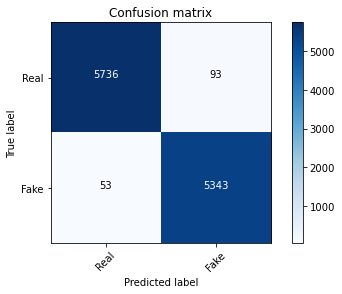

In [15]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Real', 'Fake'])

### Decision Tree Classifier

In [16]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth=20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_test, prediction)*100, 2)}")

Accuracy: 99.46


Confusion matrix, without normalization


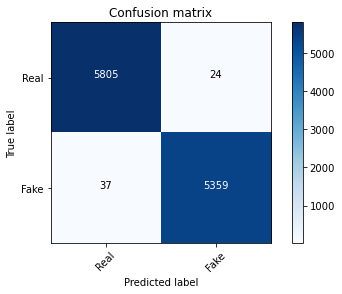

In [17]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Real', 'Fake'])

### Random Forest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_test, prediction)*100, 2)}")

Accuracy: 98.8


Confusion matrix, without normalization


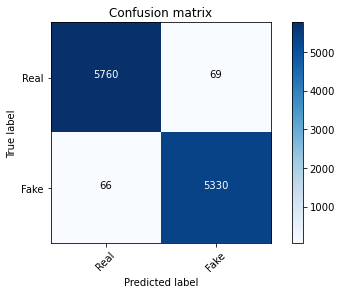

In [19]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Real', 'Fake'])

### Adaboost Classifier

In [14]:
from sklearn.ensemble import AdaBoostClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', AdaBoostClassifier(random_state=42))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_test, prediction)*100, 2)}")

Accuracy: 99.51


Confusion matrix, without normalization


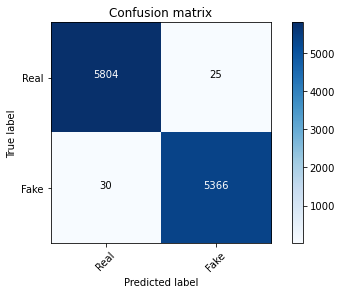

In [15]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Real', 'Fake'])

### Save Model

In [16]:
import joblib

save_model = joblib.dump(model, f'{os.path.dirname(os.getcwd())}/src/models/fake_news/model.joblib')